In [13]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import random 
import os
import cv2
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import albumentations as A
from numpy._core.defchararray import join, mod
import  torch.nn as nn
from torch._C import device
import torch.optim as optim
import torch.autograd.grad_mode as grad_mode
from torch.autograd import Function as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
device

device(type='cpu')

In [9]:
def img_show(number : int, title : str = None, size : int = 5):

    root = "../artifacts/raw/"
    image = cv2.imread(root + "Images/" + str(number) + ".jpeg")
    file = open(root + "Labels/" + str(number) + ".txt", 'r')
    txt_data = file.readlines()
    file.close()

    for i in range(0, int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0], indices[1])
        end_point = (indices[2], indices[3])

        cv2.rectangle(image, start_point, end_point, color = (0,0,255), thickness = 2)

    aspect_ratio = image.shape[0] / image.shape[1]

    plt.figure(figsize = (size + aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB ))
    plt.title(title + txt_data[0])
    plt.show()

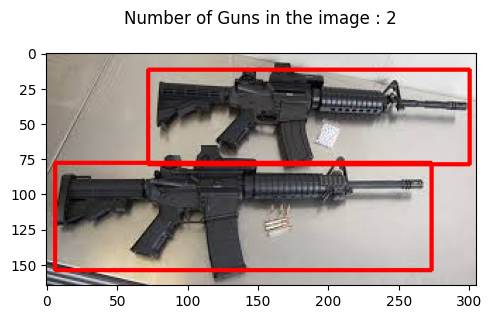

In [12]:
img_show(119, "Number of Guns in the image : ")

In [15]:
class GunData(Dataset):
    def __init__(self, root):

        self.image_path = root + "Images/"
        self.labels_path = root + "Labels/"
        self.img_name = [img for img in sorted(os.listed(self.image_path))]
        self.label_name = [label for label in sorted(os.listed(self.labels_path))]

    def __get__(self, idx):

        image_path = os.path.join(self.image_path, str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        image_res = img_rgb/255
        image_res = torch.as_tensor(image_res).permute(2,0,1)

        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path, str(label_name))


        with open(label_path, 'r') as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline.split())))
            
        target = {}
        area = []
        labels = []

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor(["idx"])
        target["labels"] = torch.as_tensor(labels, dtype = torch.int64)

        img_res = img_res.to(device)

        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key.to(device)]

        return img_res, target
    

    def __len__(self):
        return len(self.img_name)